<a href="https://colab.research.google.com/github/invest41/Studying_Reactions_to_Vaccines/blob/main/Update_of_Studying_Reactions_To_VACCINES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exploratory and Predictive Data Analytics on documented adverse effects of Vaccination**

This Notebook contains scrupulous data analytics which involves:
- Extensive Data cleaning, wrangling, analysis and visualizations

- Building working Machine Learning models with high predictive capabilities

- Using proper computational algorithms and visualizations to derive insights from real-world Data ( i.e. Who is more likely to develop adverse reactions to vaccination )

- Involves an interactive session where we apply our Machine Learning Model to answer tough questions ( i.e. Given a case note report of individual patient bio-data and clinical history, we'd use our model to predict those who are likely to survive adverse reactions to COVID19 vaccination? )

- Key graphs on survivor demographics are in place

> *Set up environment*

In [13]:
#6:30pm 17-02-2021
#Creating the right environment - Library and Module Import
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf, keras as krs
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.linear_model import LogisticRegression as LRG
 
from sklearn.metrics import accuracy_score as acsc, precision_recall_fscore_support as PRFS
from sklearn.model_selection import train_test_split as tts
import joblib, time, warnings
warnings.filterwarnings('ignore')
import string, nltk


print('Environment is set...')

Environment is set...


> *General Vaccination Data Analysis and Visualization*

> Dataset Access

In [ ]:
#Update
#8:45pm 16-07-2021
!pip install kaggle
import os

In [ ]:
#Importing Dataset from kaggle
os.environ['KAGGLE_USERNAME'] = "Generate your Kaggle API"
os.environ['KAGGLE_KEY'] = "Generate your Kaggle API"

In [ ]:
!kaggle datasets download -d ayushggarg/covid19-vaccine-adverse-reactions

 59% 5.00M/8.53M [00:00<00:00, 35.0MB/s]
100% 8.53M/8.53M [00:00<00:00, 41.8MB/s]


In [28]:
from zipfile import ZipFile as ZF
file = "covid19-vaccine-adverse-reactions.zip"
 
with ZF(file,'r') as zip:
  lst = zip.namelist()
  print('Extracting All...')
  zip.extractall()
  #zip.extractall('vaccine')
  print('Done...')

Extracting All...
Done...


In [29]:
import time

fw, err = open('2021_adverse_vaccine.csv','w'), {}
co = wh= 0
for line in open('2021VAERSDATA.csv','rb'):
	try: 
		line = line.decode()
		for ordc in [ ord(c) for c in line ]:
			if ordc>128:	line = line.replace(chr(ordc),' ')
		fw.write(line)
		wh += 1
	except Exception as e: 
		#print(e)
		err[co] = (e,line)
	co += 1
print(f'{wh} lines have been written\n{len(err)} lines are errors')
fw.close()

33762 lines have been written
360 lines are errors


In [31]:
#6:37pm 17-02-2021
#Data Cleaning
 
#1.0
orig_df = pd.read_csv('2021_adverse_vaccine.csv')
df = orig_df.copy()
print(f'Dataset Headers:\n{df.columns}')
 
#2.0 - Represent the Dimorphic Sex
df['SEX'][df['SEX']=='male'], df['SEX'][df['SEX']=='female'] = 1, 0
 
#3.0 - Circumvent Errors
df = df.fillna(0)
df = df.replace('N', 0)
df = df.replace('Y', 1)
df = df.replace('U', 0.5)
df = df.replace('F', 0)
df = df.replace('M', 1)

Dataset Headers:
Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')


Text(0.5, 0, 'Age (in years)')

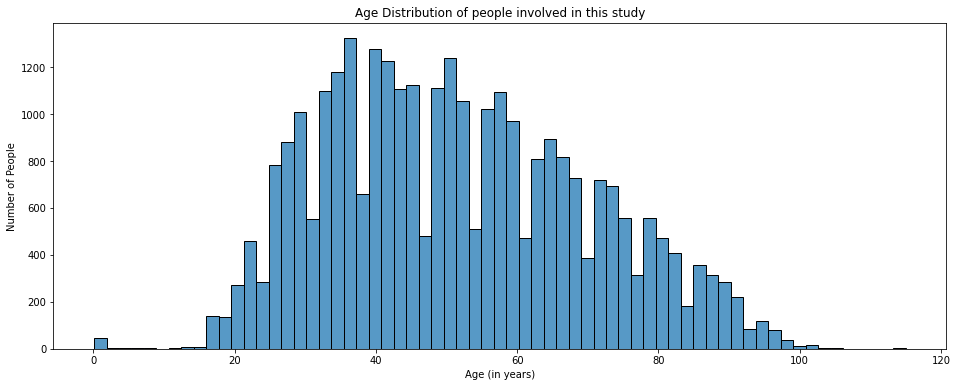

In [107]:
plt.figure(figsize=(16,6))
sns.histplot(df['AGE_YRS'][df['AGE_YRS']>0])
plt.title('Age Distribution of people involved in this study')
plt.ylabel('Number of People')
plt.xlabel('Age (in years)')

Text(0.5, 0, 'Age (in years)')

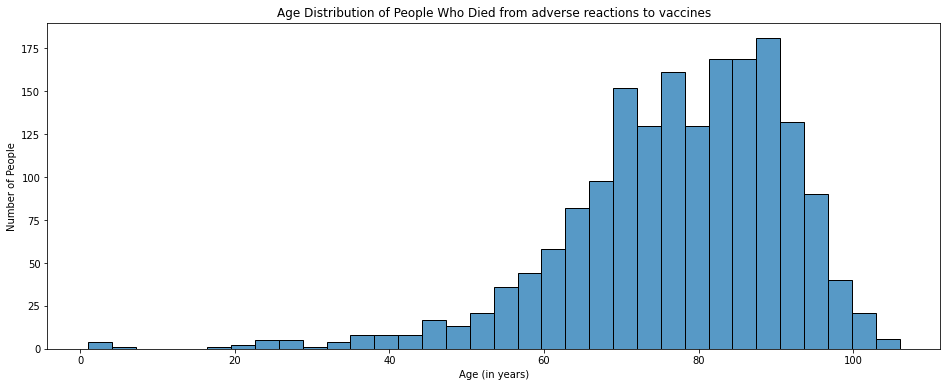

In [106]:
#Studying the death Factors
death_df = df[df['DIED']==1]
 
 
dist = death_df[death_df['AGE_YRS']>0]
plt.figure(figsize=(16,6))
sns.histplot(dist['AGE_YRS'])
plt.title('Age Distribution of People Who Died from adverse reactions to vaccines')
plt.ylabel('Number of People')
plt.xlabel('Age (in years)')

Text(0.5, 1.0, 'Death per State')

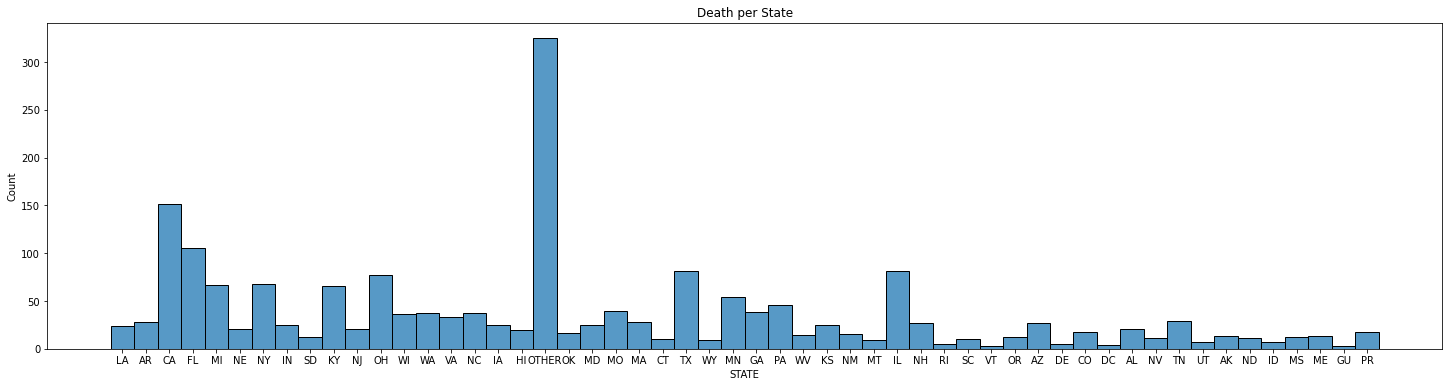

In [34]:
plt.figure(figsize=(25,6))
death_df['STATE'] = orig_df['STATE'].fillna('OTHER')

sns.histplot(death_df['STATE'])
plt.title('Death per State')

Text(0.5, 0, 'STATE')

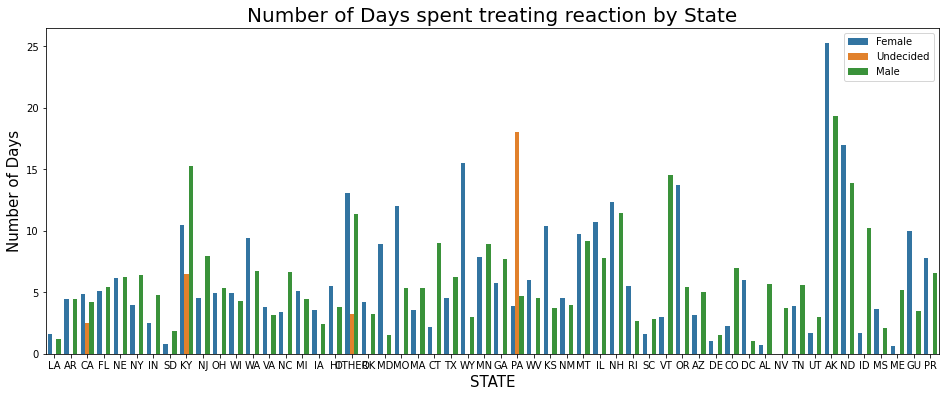

In [35]:
plt.figure(figsize=(16,6))
sns.barplot(x='STATE', y='NUMDAYS',hue='SEX', data = death_df[death_df['NUMDAYS']<100], ci = None)
plt.legend(['Female','Undecided','Male'], loc='upper right')
plt.title('Number of Days spent treating reaction by State',fontsize=20)
plt.ylabel('Number of Days',fontsize=15)
plt.xlabel('STATE',fontsize=15)

In [36]:
#Analysis of patient history
#Data formating
 
nltk.download('words')
fwl = nltk.corpus.words.words()
 
def transcribe(word,p):
    code = word.maketrans(p,' ','')
    return word.translate(code)
dct, lst1, lst2 = {}, [], []
 
for line in [ str(his)+',' for his in list(death_df['HISTORY'].values)]:
  line = line.split(',')
  for word in line:
    word = word.strip()
    for p in string.punctuation:
        if p in word: 
          word = transcribe(word, p)
 
    word = word.strip('\n 0').capitalize()
    if not (word==" " and word.capitalize()=="None"): 
      #if word in fwl:
       if 50>len(word)>4: 
        dct[word] = dct.get(word, 0) + 1
co = 0
for v,k in sorted([(v,k) for k,v in dct.items()], reverse=True):
  co+=1
  if co==1: continue
  lst1.append(k)
  lst2.append(v)
 
p_history = pd.DataFrame({'Personal_history':lst1,'Frequency':lst2}).replace('',)
 
print('\nDataset Ready - p_history')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!

Dataset Ready - p_history


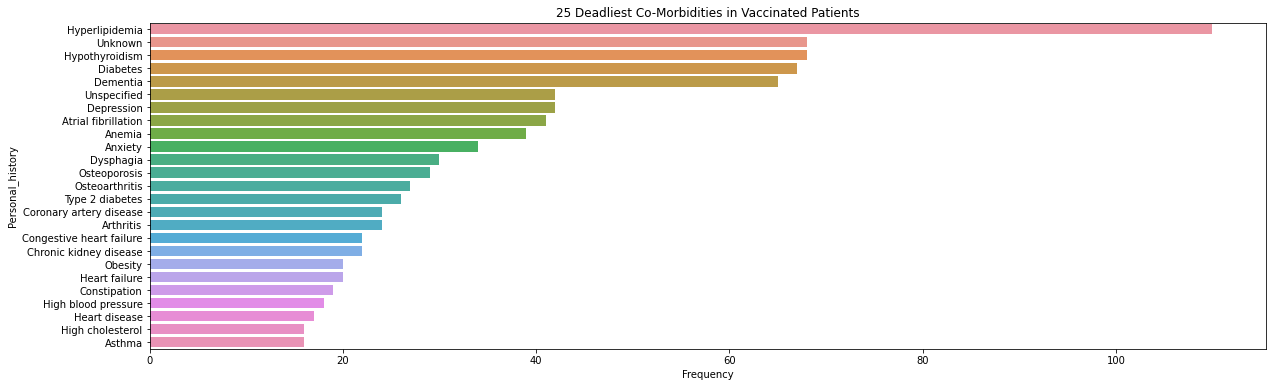

<Figure size 1152x720 with 0 Axes>

In [37]:
plt.figure(figsize=(20,6))
sns.barplot(x='Frequency', y='Personal_history', data=p_history.head(25)) 
plt.title('25 Deadliest Co-Morbidities in Vaccinated Patients')
plt.figure(figsize=(16,10))
plt.savefig('deadly_co-morbidities.png')

In [38]:
df.head(2)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,0.0,0.0,0,Right side of epiglottis swelled up and hinder...,0,0,0,0,0,0.0,0,0,1.0,12/28/2020,12/30/2020,2.0,None,PVT,0,None,None,None,0,0,2,01/01/2021,0,1,0,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,0.0,0.0,0,Approximately 30 min post vaccination administ...,0,0,0,0,0,0.0,0,0,1.0,12/31/2020,12/31/2020,0.0,0,SEN,0,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,0,0,2,01/01/2021,0,1,0,"""Dairy"""


In [39]:
#Merge to full Dataset
adj = pd.read_csv('2021VAERSSYMPTOMS.csv')
par_new_df = orig_df.merge(adj,on='VAERS_ID')
adj2 = pd.read_csv('2021VAERSVAX.csv')
new_df = par_new_df.merge(adj2,on='VAERS_ID')
print('Dataset ready - new_df')

Dataset ready - new_df


In [40]:
 #1.0
copy_new_df = new_df.copy()
print(f'Dataset Headers:\n{new_df.columns}')
 
#2.0 - Represent the Dimorphic Sex
new_df['SEX'][new_df['SEX']=='male'], new_df['SEX'][new_df['SEX']=='female'] = 1, 0
 
#3.0 - Circumvent Errors
new_df = new_df.fillna(0)
new_df = new_df.replace('N', 0)
new_df = new_df.replace('Y', 1)
new_df = new_df.replace('U', 0.5)
new_df = new_df.replace('F', 0)
new_df = new_df.replace('M', 1)

Dataset Headers:
Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'SYMPTOM1', 'SYMPTOMVERSION1', 'SYMPTOM2',
       'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4',
       'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5', 'VAX_TYPE',
       'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE',
       'VAX_NAME'],
      dtype='object')


# *Exploratory Data Analysis and Visualization*

- *COVID19 VACCINE*

Text(0.5, 0, 'STATE')

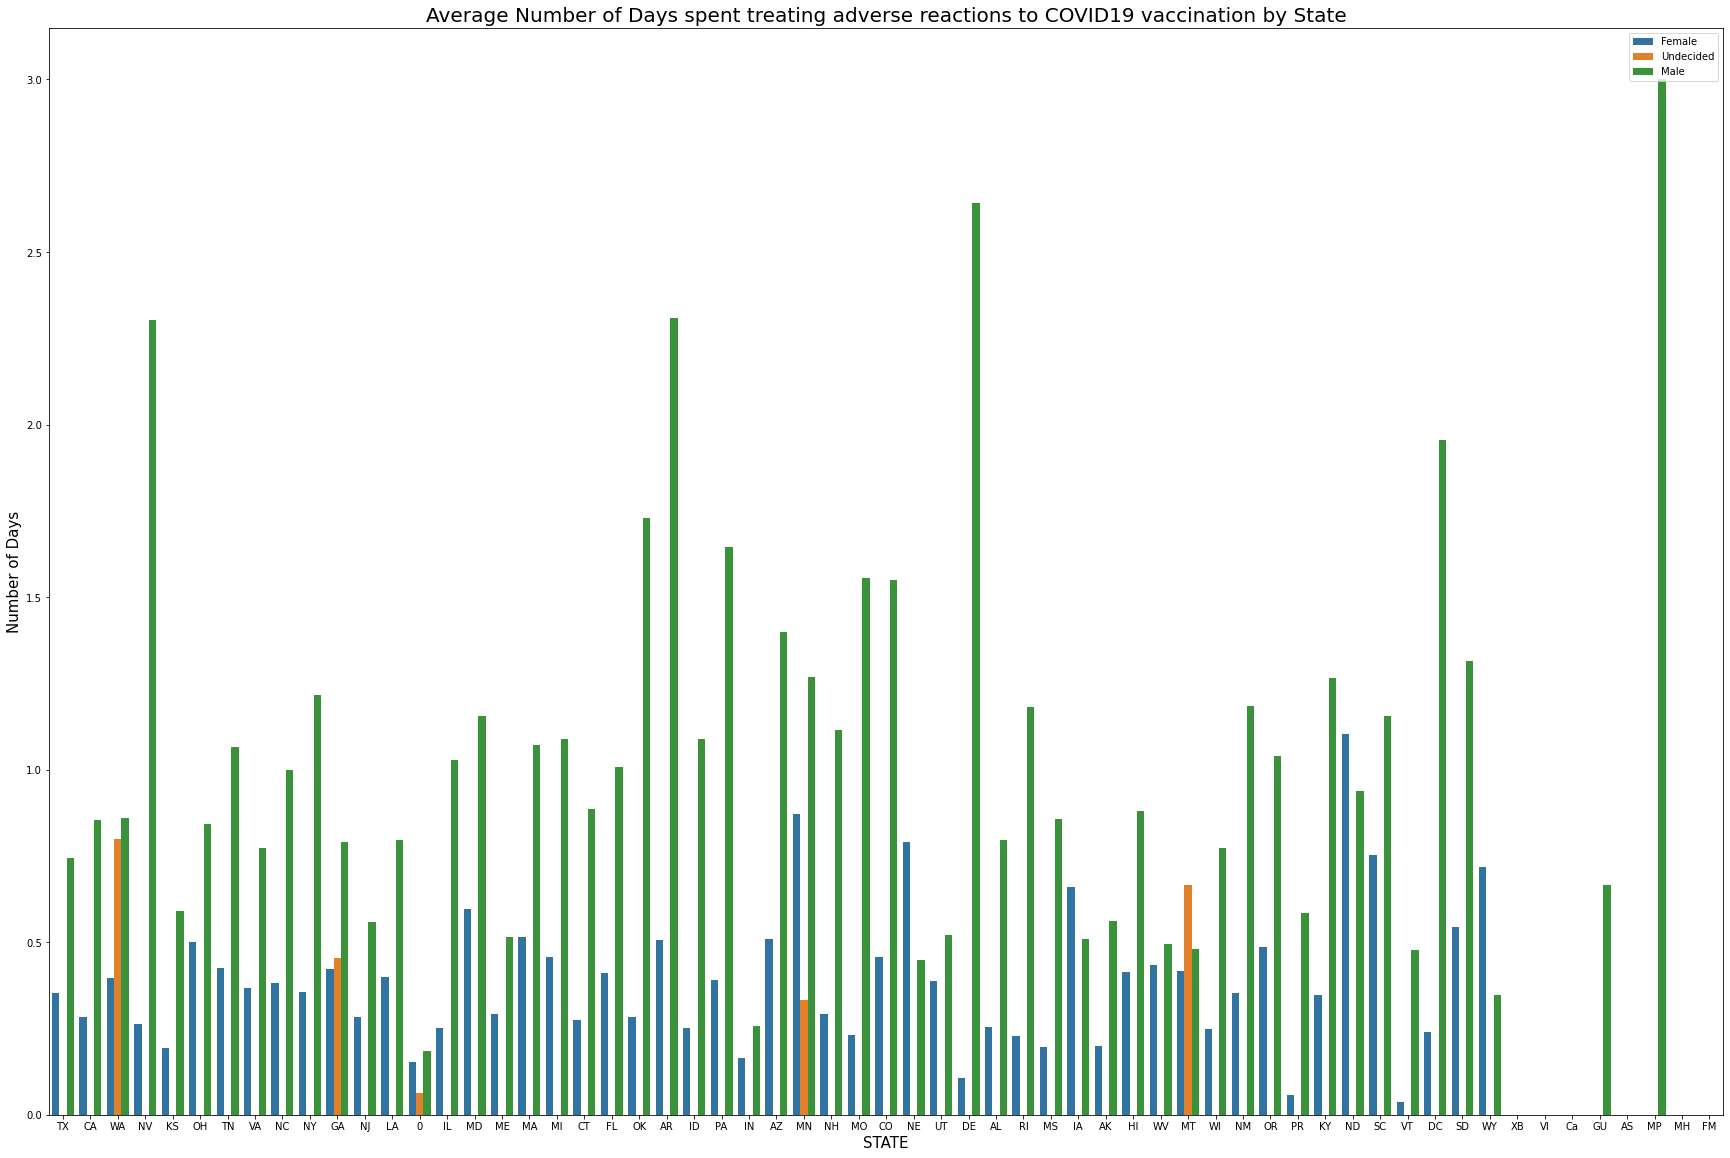

In [41]:
#1.0
corona_vac_df = new_df[new_df['VAX_TYPE']=='COVID19']

#2.0
plt.figure(figsize=(30,20))
sns.barplot(x='STATE', y='HOSPDAYS',hue='SEX', data = corona_vac_df, ci = None)
plt.legend(['Female','Undecided','Male'], loc='upper right')
plt.title('Average Number of Days spent treating adverse reactions to COVID19 vaccination by State',fontsize=20)
plt.ylabel('Number of Days',fontsize=15)
plt.xlabel('STATE',fontsize=15)

Text(0.5, 0, 'STATE')

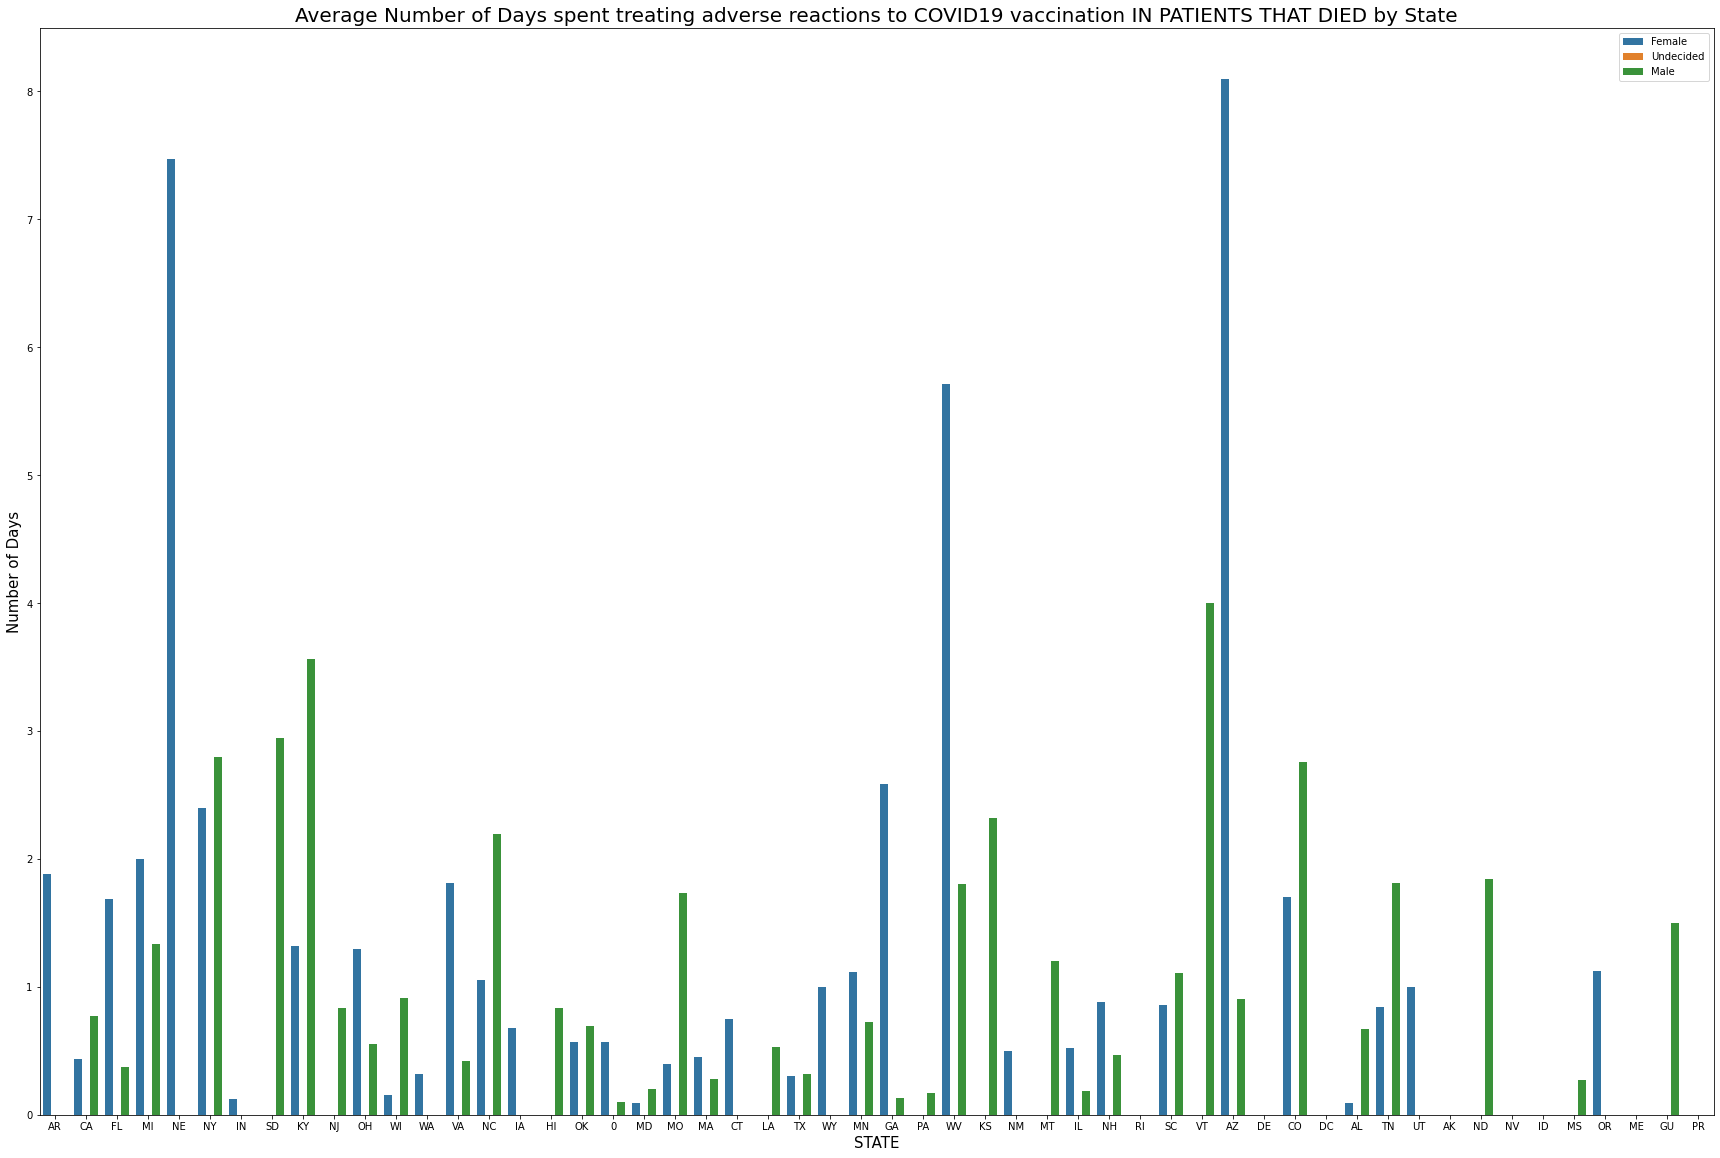

In [42]:
 #1.0
corona_vac_df = new_df[new_df['VAX_TYPE']=='COVID19']
 
#2.0
plt.figure(figsize=(30,20))
sns.barplot(x='STATE', y='HOSPDAYS', hue='SEX', data = corona_vac_df[new_df['DIED']==1], ci = None)
plt.legend(['Female','Undecided','Male'], loc='upper right')
plt.title('Average Number of Days spent treating adverse reactions to COVID19 vaccination IN PATIENTS THAT DIED by State',fontsize=20)
plt.ylabel('Number of Days',fontsize=15)
plt.xlabel('STATE',fontsize=15)

In [43]:
#corona_vac_df[['ALLERGIES']][new_df['DIED']==1].value_counts().head(25).plot.bar()
 
#Analysis of the allergy history of reactive patients, generally and for the Dead
#Data formating
 
nltk.download('words')
fwl = nltk.corpus.words.words()
 
def transcribe(word,p):
    code = word.maketrans(p,' ','')
    return word.translate(code)
 
comp = list(corona_vac_df['VAX_MANU'].unique())
cou = 0
for corp in comp:
  cou+=1
  dct3, lst5, lst6, turn = {}, [], [], 0
  for cat in [[ str(his)+',' for his in list(corona_vac_df['ALLERGIES'][corona_vac_df['VAX_MANU']==f'{corp}'].values)],
               [ str(his)+',' for his in list(corona_vac_df['ALLERGIES'][corona_vac_df['DIED']==1][corona_vac_df['VAX_MANU']==f'{corp}'].values)]]:
               
               for line in cat:
                 for word in line.split(','):
                   word = word.strip()
                   for p in string.punctuation:
                     if p in word:
                       word = transcribe(word, p)
                   word = word.strip('\n 0').capitalize()
                   if not (word==" " and word.capitalize()=="None"):
                     #if word in fwl:
                     if 50>len(word)>4:
                       if word=='Penicillins': word = 'Penicillin'
                       dct3[word] = dct3.get(word, 0) + 1
               co = 0
               for v,k in sorted([(v,k) for k,v in dct3.copy().items()], reverse=True):
                 co+=1
                 if co==1: continue
                 lst5.append(k)
                 lst6.append(v)
                 
               d = pd.DataFrame({'Allergy_history':lst5[:],'Frequency':lst6[:]}).replace('',)
 
               
               temp = '\nDatasets ready '
               if cou==1: 
                if turn==0:
                  alleg_moderna = d.copy()
                  dct3, lst5, lst6, turn = {}, [], [], 1
                  continue
                d_alleg_moderna = d.copy()
                print(temp + '- alleg_moderna, d_alleg_moderna')
               elif cou==2: 
                if turn==0:
                  alleg_pfizer_biontech = d.copy()
                  dct3, lst5, lst6, turn = {}, [], [], 1
                  continue
                d_alleg_pfizer_biontech = d.copy()
                print(temp + '- alleg_pfizer_biontech, d_alleg_pfizer_biontech')
               elif cou==3: 
                if turn==0:
                  alleg_unknown = d.copy()
                  dct3, lst5, lst6, turn = {}, [], [], 1
                  continue
                d_alleg_unknown = d.copy()
                print(temp + '- alleg_unknown, d_alleg_unknown')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!

Datasets ready - alleg_moderna, d_alleg_moderna

Datasets ready - alleg_pfizer_biontech, d_alleg_pfizer_biontech

Datasets ready - alleg_unknown, d_alleg_unknown


In [44]:
#Manufacturers of the COVID19 vaccines studied
corona_vac_df['VAX_MANU'].unique()

array(['MODERNA', 'PFIZER\\BIONTECH', 'UNKNOWN MANUFACTURER', 'JANSSEN'],
      dtype=object)

In [45]:
#Dead patients' allergy history (Pfizer/BioNTech section)
d_alleg_pfizer_biontech.head(10)

,Allergy_history,Frequency
0,Penicillin,50
1,Lactose,42
2,Unknown,40
3,None known,36
4,Sulfa,20
5,Codeine,19
6,None listed,17
7,Tramadol,12
8,Lisinopril,11
9,Itching,10


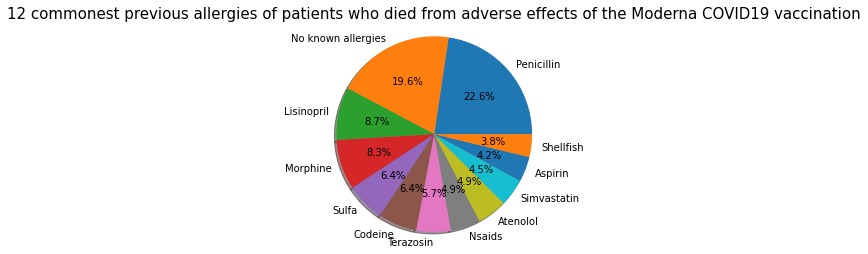

<Figure size 1440x720 with 0 Axes>

In [46]:
 
labels1 = d_alleg_moderna['Allergy_history'].head(12)
sizes1 = d_alleg_moderna['Frequency'].head(12)
 
 
fig1, ax1 = plt.subplots()
 
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
 
 
 
plt.title('12 commonest previous allergies of patients who died from adverse effects of the Moderna COVID19 vaccination', fontsize=15)
 
plt.savefig("Deadly_Allergy_for_Moderna_Covid19_Vaccine_Chart.png")
plt.figure(figsize=(20,10))
plt.show()

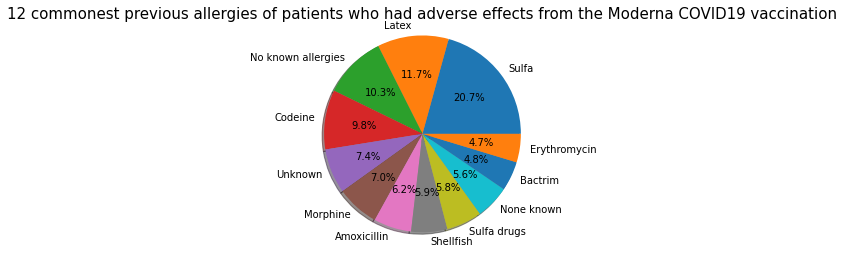

<Figure size 1440x720 with 0 Axes>

In [47]:
labels2 = alleg_moderna['Allergy_history'].head(12)
sizes2 = alleg_moderna['Frequency'].head(12)
 
fig2, ax2 = plt.subplots()
 
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', shadow=True)
ax2.axis('equal')
 
 
plt.title('12 commonest previous allergies of patients who had adverse effects from the Moderna COVID19 vaccination', fontsize=15)
plt.savefig("Dangerous_Allergy_for_Moderna_Covid19_Vaccine_Chart.png")
plt.figure(figsize=(20,10))
plt.show()

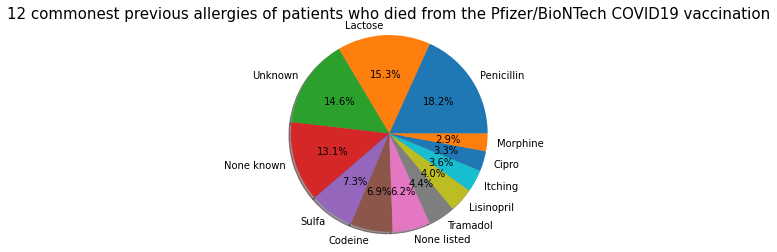

<Figure size 2160x1440 with 0 Axes>

In [48]:

labels3 = d_alleg_pfizer_biontech['Allergy_history'].head(12)
sizes3 = d_alleg_pfizer_biontech['Frequency'].head(12)
 
 
fig3, ax = plt.subplots()
 
ax.pie(sizes3, labels=labels3, autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.title('12 commonest previous allergies of patients who died from the Pfizer/BioNTech COVID19 vaccination', fontsize=15)
plt.savefig("Deadly_Allergy_for_PNB_Covid19_Vaccine_Chart.png")
plt.figure(figsize=(30,20))
plt.show()

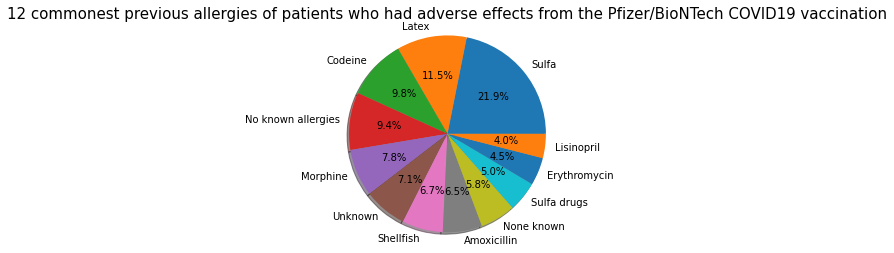

<Figure size 2160x1440 with 0 Axes>

In [49]:
labels4 = alleg_pfizer_biontech['Allergy_history'].head(12)
sizes4 = alleg_pfizer_biontech['Frequency'].head(12)
 
 
fig4, ax = plt.subplots()
 
ax.pie(sizes4, labels=labels4, autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.title('12 commonest previous allergies of patients who had adverse effects from the Pfizer/BioNTech COVID19 vaccination', fontsize=15)
plt.savefig("Dangerous_Allergy_for_PNB_Covid19_Vaccine_Chart.png")
plt.figure(figsize=(30,20))
plt.show()

In [50]:
#Dead patient assessment
 
#1.0
def transcribe(word,p):
    code = word.maketrans(p,' ','')
    return word.translate(code)
num = list(range(1,6))
#2.0
for n in num:
  dct2, lst7, lst8 = {}, [], []
  for i in corona_vac_df[f'SYMPTOM{n}'][new_df['DIED']==1]: 
    i = str(i).strip().capitalize()
    for p in string.punctuation:
        if p in i: 
          i = transcribe(i, p)
    if (not i.isdigit()) and (i.isalpha() or i.isalnum()): dct2[i] = dct2.get(i, 0) + 1
    
  #3.0
  co = 0
  for v,k in sorted([(v,k) for k,v  in dct2.copy().items()], reverse=True):
      co+=1
      if co==1: continue
      lst7.append(k)
      lst8.append(int(v))
  
  #4.0
  x = pd.DataFrame({f'Patient_Symptom_{n}':lst7[:], 'Frequency':lst8[:]})
  if n==1: p_sym_1_df = x.copy()
  elif n==2: p_sym_2_df = x.copy()
  elif n==3: p_sym_3_df = x.copy()
  elif n==4: p_sym_4_df = x.copy()
  elif n==5: p_sym_5_df = x.copy()
  print(f'Dataset Ready - p_sym_{n}_df')

Dataset Ready - p_sym_1_df
Dataset Ready - p_sym_2_df
Dataset Ready - p_sym_3_df
Dataset Ready - p_sym_4_df
Dataset Ready - p_sym_5_df


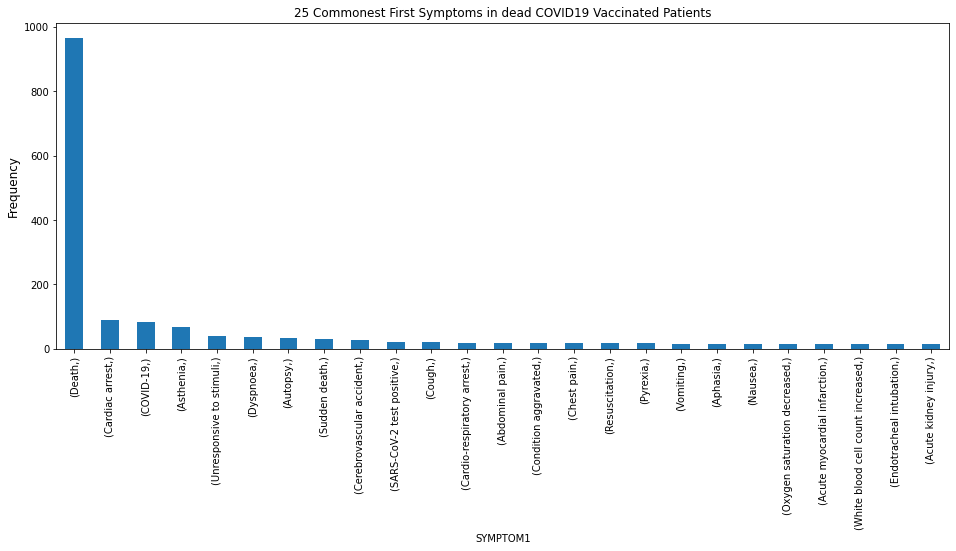

<Figure size 1152x720 with 0 Axes>

In [105]:
 
nb,nam = 1, 'first'
plt.figure(figsize=(16,6))
 
corona_vac_df[['SYMPTOM1']][new_df['DIED']==1].value_counts()[:25].plot.bar()
 
 
plt.title(f'25 Commonest {nam.capitalize()} Symptoms in dead COVID19 Vaccinated Patients')
plt.ylabel('Frequency', fontsize=12)
plt.figure(figsize=(16,10))
plt.savefig(f'commonest_{nam.lower()}_symptoms{nb}.png')

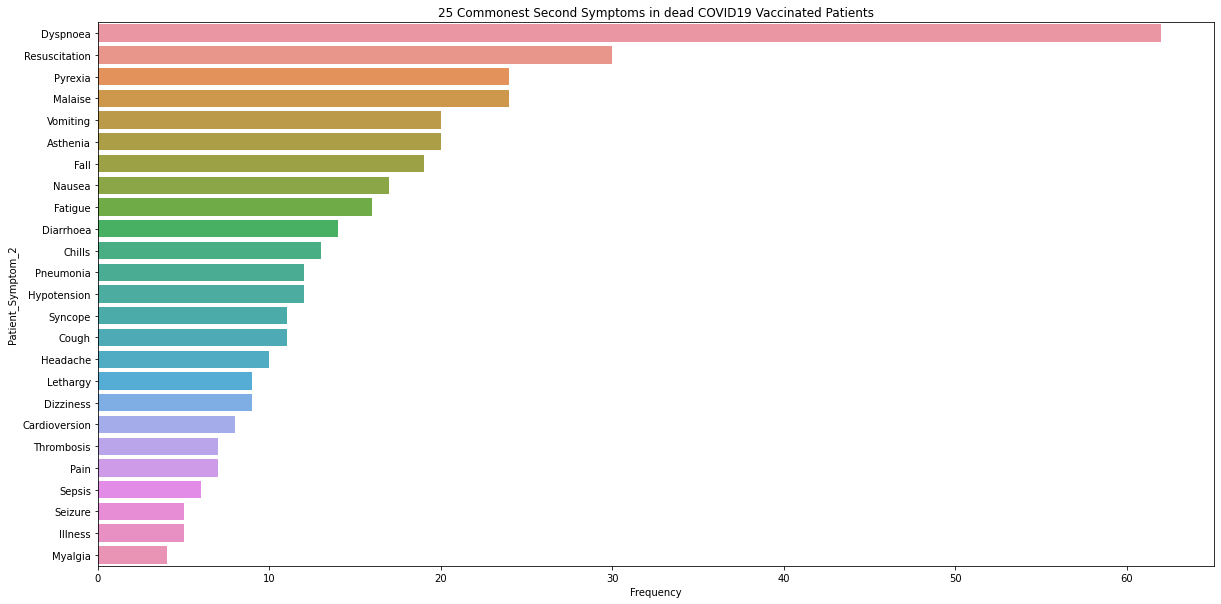

In [52]:
 
 
nb,nam = 2, 'second'
plt.figure(figsize=(20,10))
sns.color_palette('mako',as_cmap=True)
sns.barplot(x='Frequency', y=f'Patient_Symptom_{nb}', data=p_sym_2_df.head(25))
plt.title(f'25 Commonest {nam.capitalize()} Symptoms in dead COVID19 Vaccinated Patients')
plt.savefig(f'commonest_{nam.lower()}_symptoms{nb}.png')

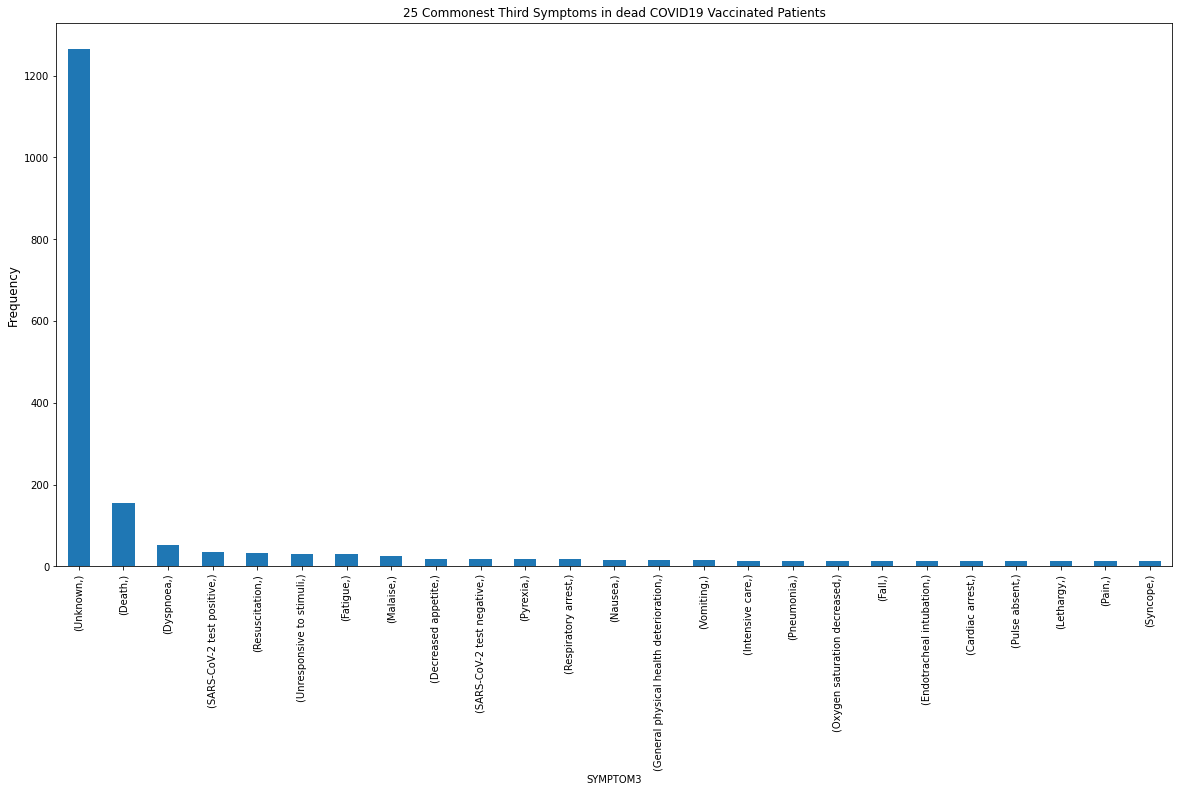

In [53]:
 
 
nb,nam = 3, 'third'
plt.figure(figsize=(20,10))
corona_vac_df['SYMPTOM3'][corona_vac_df['SYMPTOM3']==0] = 'Unknown'
corona_vac_df[['SYMPTOM3']][new_df['DIED']==1].value_counts().head(25).plot.bar()
plt.title(f'25 Commonest {nam.capitalize()} Symptoms in dead COVID19 Vaccinated Patients')
plt.ylabel('Frequency',fontsize=12)
plt.savefig(f'commonest_{nam.lower()}_symptoms{nb}.png')

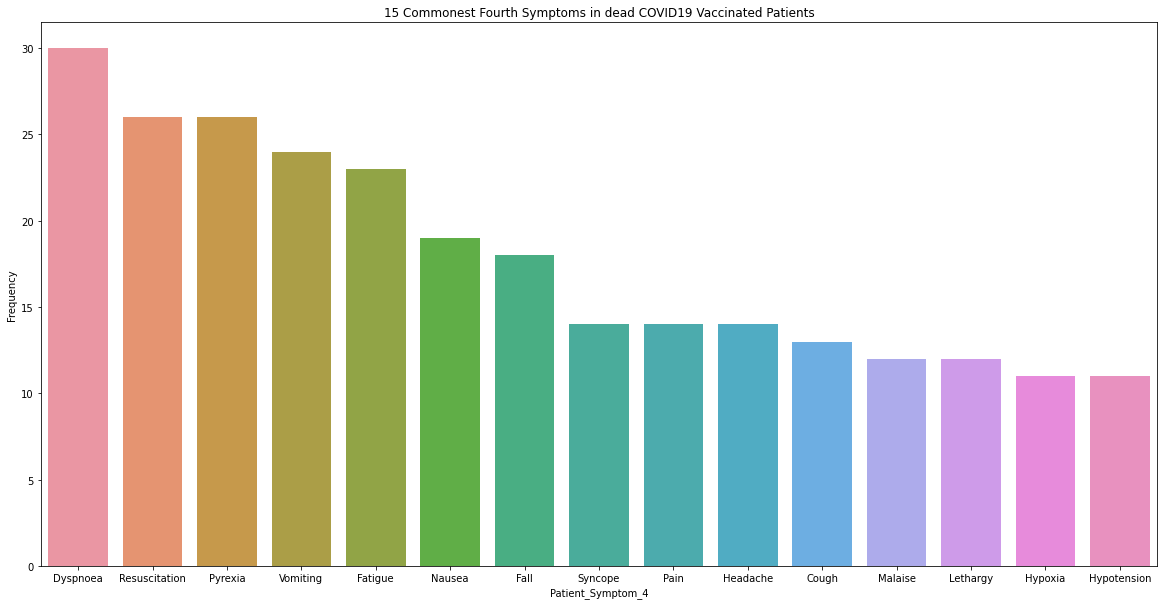

<Figure size 1152x720 with 0 Axes>

In [54]:
 
 
nb,nam = 4, 'fourth'
plt.figure(figsize=(20,10))
sns.barplot(y='Frequency', x=f'Patient_Symptom_{nb}', data=p_sym_4_df.head(15)) 
plt.title(f'15 Commonest {nam.capitalize()} Symptoms in dead COVID19 Vaccinated Patients')
plt.figure(figsize=(16,10))
plt.savefig(f'commonest_{nam.lower()}_symptoms{nb}.png')

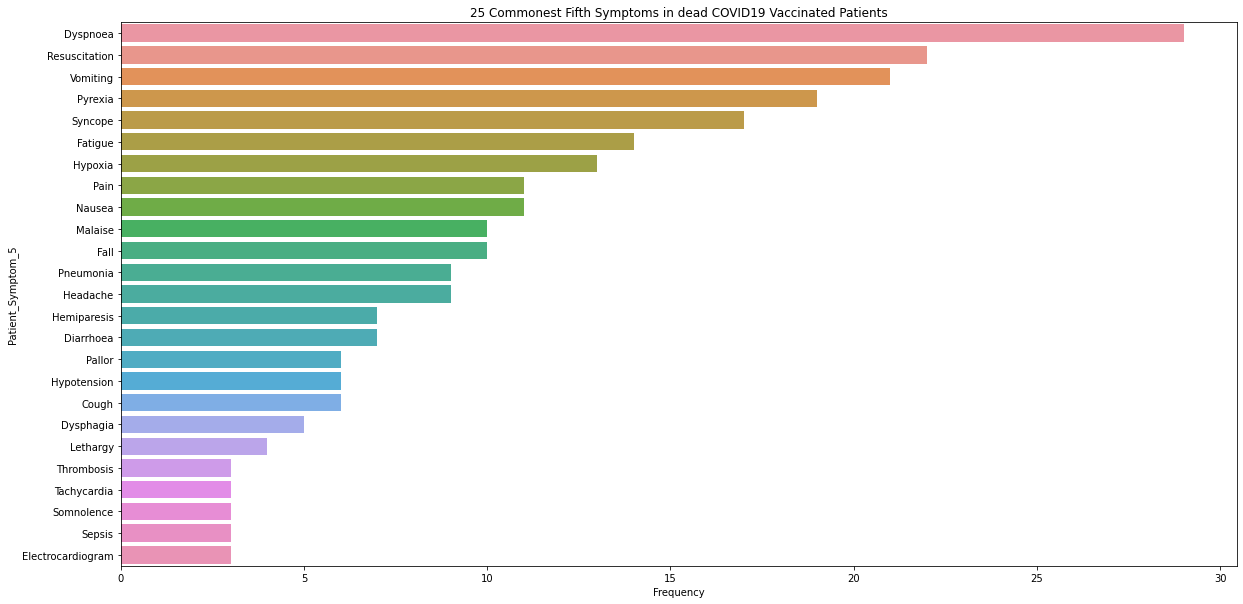

<Figure size 1152x720 with 0 Axes>

In [55]:
 
 
nb,nam = 5, 'fifth'
plt.figure(figsize=(20,10))
sns.barplot(x='Frequency', y=f'Patient_Symptom_{nb}', data=p_sym_5_df.head(25)) 
plt.title(f'25 Commonest {nam.capitalize()} Symptoms in dead COVID19 Vaccinated Patients')
plt.figure(figsize=(16,10))
plt.savefig(f'commonest_{nam.lower()}_symptoms{nb}.png')

In [56]:
corona_vac_df.tail(2)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
48020,1115045,03/19/2021,AZ,57.0,0.0,0.0,1.0,0,Death; A spontaneous report was received from ...,1,03/02/2021,0,0,0,0.0,0,0,0.0,03/02/2021,03/02/2021,0.0,0,UNK,0,0,0,Medical History/Concurrent Conditions: No adve...,0,"USMODERNATX, INC.MOD20210",2,03/15/2021,0,0,0,0,Death,23.1,0,0.0,Unknown,0.0,0,0.0,0,0.0,COVID19,MODERNA,0,2,OT,0,COVID19 (COVID19 (MODERNA))
48021,1115348,03/19/2021,NC,0.0,85.0,0.0,0.0,0,death; A spontaneous report was received from ...,1,03/06/2021,0,0,0,0.0,0,0,0.0,03/05/2021,03/06/2021,1.0,0,UNK,0,0,0,Comments: List of non-encoded Patient Relevant...,0,"USMODERNATX, INC.MOD20210",2,03/12/2021,0,0,0,0,Death,23.1,0,0.0,Unknown,0.0,0,0.0,0,0.0,COVID19,MODERNA,026A21A,1,OT,LA,COVID19 (COVID19 (MODERNA))


In [ ]:
#@title


#corona_vac_df[['VAX_ROUTE']][corona_vac_df['VAX_ROUTE']==0] = 'Unknown'
plt.figure(figsize=(16,8))
corona_vac_df[['VAX_ROUTE']].replace(0,'Unknown').value_counts().plot(subplots=True, kind="bar")
plt.ylabel('Frequency',fontsize=12)
plt.title('Commonest Routes of COVID19 Vaccine Administration – generally')

Text(0.5, 1.0, 'Commonest Routes of COVID19 Vaccine Administration – in deceased patients')

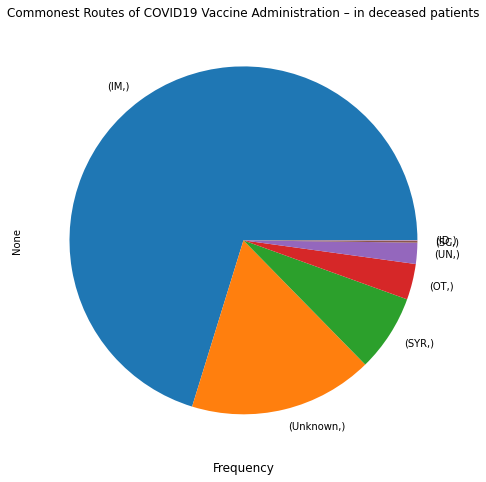

In [58]:
#@title


#corona_vac_df[['VAX_ROUTE']][corona_vac_df['VAX_ROUTE']=='None'] = 'Unknown'
plt.figure(figsize=(16,8))
corona_vac_df[['VAX_ROUTE']][new_df["DIED"]==1].replace(0,'Unknown').value_counts().plot(kind="pie")
plt.xlabel('Frequency',fontsize=12)
plt.title('Commonest Routes of COVID19 Vaccine Administration – in deceased patients')

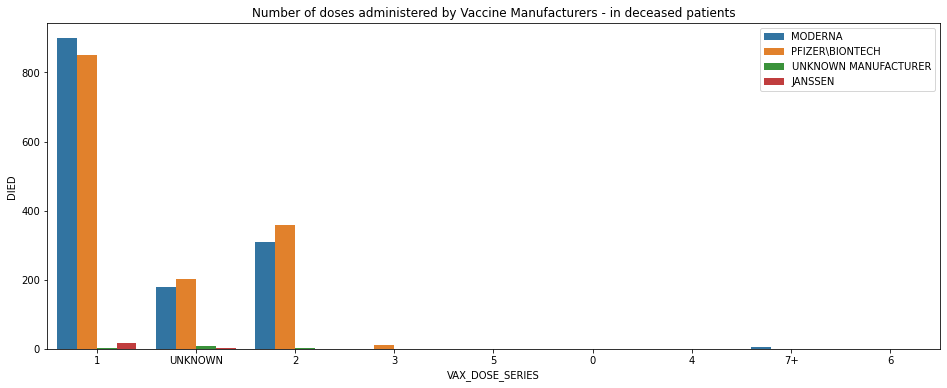

In [59]:
plt.figure(figsize=(16,6))
corona_vac_df['VAX_DOSE_SERIES'] = corona_vac_df['VAX_DOSE_SERIES'].replace('UNK','UNKNOWN')
sns.barplot(x = "VAX_DOSE_SERIES", y = "DIED", hue = "VAX_MANU", data = corona_vac_df, ci=None, estimator=sum)


plt.title("Number of doses administered by Vaccine Manufacturers - in deceased patients")
plt.legend(loc='upper right')
plt.savefig("covid19_vaccine_dose_risk_by_manufacturer.png")

#Applying Machine Learning to predict patient mortality
- Supervised Learning

In [60]:
#Given a set of patient bio-data and history 
#what are the chances of an adverse reaction
#to the Vaccine (dataset used -  COVID19 vaccine)

- **STEP 1**

In [61]:
#1.0 - Preparing the dataset for Machine Learning
md = corona_vac_df.copy()
states, st_dct = md['STATE'].unique(), {}
 
#2.1 - Representing States as Numbers
co = 0
for st in states:
  co+=1
  md['STATE'][md['STATE']==st] = co
  st_dct[st] = co
 
#2.2 - Representing Facility of vaccination administration as Numbers
cou = 0
fac, fac_dct = md['V_ADMINBY'].unique(), {}
for fc in fac:
  cou+=1
  md['V_ADMINBY'][md['V_ADMINBY']==fc] = co
  fac_dct[fc] = cou
 
  
 
 
print('States in dictionary - st_dct\nFacilities in dictionary - fac_dct')
 
 
#3.0 - Chosen parameters
para = ['STATE','AGE_YRS','SEX',"L_THREAT","ER_VISIT","HOSPITAL","HOSPDAYS","X_STAY","DISABLE","RECOVD","NUMDAYS","V_ADMINBY","FORM_VERS","BIRTH_DEFECT","OFC_VISIT","ER_ED_VISIT",
        "VAX_MANU","VAX_DOSE_SERIES","VAX_ROUTE","VAX_SITE"]
 
st_dct.pop(0)
vax_data = []
for vax in para[-4:]:
  c, d = 0, {}
  for i in md[str(vax)].unique():
    c+=1
    md[str(vax)][md[str(vax)]==i] = c
    d[i] = c
  vax_data.append(d.copy())
 
print('Vaccine parameters in list of dictionaries - vax_data')
 
#4.0 - Assess Dataset
print("\n\nComputation-Friendly Dataset")
md[para].head(5)

States in dictionary - st_dct
Facilities in dictionary - fac_dct
Vaccine parameters in list of dictionaries - vax_data


Computation-Friendly Dataset


,STATE,AGE_YRS,SEX,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,NUMDAYS,V_ADMINBY,FORM_VERS,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,VAX_MANU,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE
0,1,33.0,0.0,0,0,0,0.0,0,0,1.0,2.0,61,2,0,1,0,1,1,1,1
1,2,73.0,0.0,0,0,0,0.0,0,0,1.0,0.0,61,2,0,1,0,1,1,1,2
2,3,23.0,0.0,0,0,0,0.0,0,0,0.5,0.0,61,2,0,0,1,2,1,1,1
3,3,58.0,0.0,0,0,0,0.0,0,0,1.0,0.0,61,2,0,0,0,1,2,2,3
4,1,47.0,0.0,0,0,0,0.0,0,0,0.0,7.0,61,2,0,0,0,1,1,1,1


- ***STEP 2***

# _UNDERSTANDING PARAMETERS USED_


_Glossary:_
- STATE - United States State Symbols (translated in dictionary, st_dct)

- AGE_YRS - Age, in years

- SEX - Female is 0, Male is 1

- DIED - Death (True = 1 or False = 0)

- L_Threat - Life-Threatening Illness (True = 1 or False = 0)

- ER_VISIT - Emergency Room or Doctor Visit (True = 1 or False = 0)

- HOSPITAL - Hospitalized (True = 1 or False = 0)

- HOSPDAYS - Number of days Hospitalized

- X_STAY - Prolongation of Existing Hospitalization

- DISABLE - Disability (True = 1 or False = 0)

- RECOVD - Recovered (True = 1 or False = 0 or Undecided = 0.5)

- NUMDAYS - Number of days from Vaccination date till Onset of adverse reaction

- V_ADMINBY - Type of facility where vaccine was administered (described in dictionary, fac_dct)

- FORM_VERS - Adverse Vaccination Form (1 or 2)

- BIRTH_DEFECT - Congenital anomaly or birth defect (True = 1 or False = 0)

- OFC_VISIT - Doctor or other healthcare provider office/clinic visit (T/F)

- ER_ED_VISIT - Emergency room/department or urgent care (T/F)

- VAX_MANU - Vaccine Manufacturer (data mapping in list of dictionaries, vax_data)

- VAX_DOSE_SERIES - Number of doses administered (data mapping in list of dictionaries, vax_data)

- VAX_ROUTE - Vaccination Route (data mapping in list of dictionaries, vax_data)

- VAX_SITE - Vaccination Site (data mapping in list of dictionaries, vax_data)

In [62]:
#Data mapping of states
st_dct

{'AK': 39,
 'AL': 35,
 'AR': 23,
 'AS': 58,
 'AZ': 27,
 'CA': 2,
 'CO': 31,
 'CT': 20,
 'Ca': 56,
 'DC': 51,
 'DE': 34,
 'FL': 21,
 'FM': 61,
 'GA': 11,
 'GU': 57,
 'HI': 40,
 'IA': 38,
 'ID': 24,
 'IL': 15,
 'IN': 26,
 'KS': 5,
 'KY': 47,
 'LA': 13,
 'MA': 18,
 'MD': 16,
 'ME': 17,
 'MH': 60,
 'MI': 19,
 'MN': 28,
 'MO': 30,
 'MP': 59,
 'MS': 37,
 'MT': 42,
 'NC': 9,
 'ND': 48,
 'NE': 32,
 'NH': 29,
 'NJ': 12,
 'NM': 44,
 'NV': 4,
 'NY': 10,
 'OH': 6,
 'OK': 22,
 'OR': 45,
 'PA': 25,
 'PR': 46,
 'RI': 36,
 'SC': 49,
 'SD': 52,
 'TN': 7,
 'TX': 1,
 'UT': 33,
 'VA': 8,
 'VI': 55,
 'VT': 50,
 'WA': 3,
 'WI': 43,
 'WV': 41,
 'WY': 53,
 'XB': 54}

In [63]:
print(f"COVID19 vaccine facilities: \n{fac_dct}")

COVID19 vaccine facilities: 
{'PVT': 1, 'SEN': 2, 'WRK': 3, 'PUB': 4, 'OTH': 5, 'UNK': 6, 'PHM': 7, 'MIL': 8, 'SCH': 9}


In [64]:
print(f"COVID19 manufacturers: {vax_data[0]}")
print(f"Vaccination Number: {vax_data[1]}")
print(f"Vaccination Route: {vax_data[2]}")
print(f"Vaccination Site: {vax_data[3]}")

COVID19 manufacturers: {'MODERNA': 1, 'PFIZER\\BIONTECH': 2, 'UNKNOWN MANUFACTURER': 3, 'JANSSEN': 4}
Vaccination Number: {'1': 1, 'UNKNOWN': 2, '2': 3, '3': 4, '5': 5, 0: 6, '4': 7, '7+': 8, '6': 9}
Vaccination Route: {'IM': 1, 0: 2, 'SYR': 3, 'JET': 4, 'UN': 5, 'SC': 6, 'ID': 7, 'OT': 8}
Vaccination Site: {'LA': 1, 'RA': 2, 0: 3, 'AR': 4, 'UN': 5, 'GM': 6, 'LL': 7, 'OT': 8, 'RL': 9, 'LG': 10}


- ***STEP 3***

In [65]:
# Predicting Mortality Outcome from Patient Bio-Data and History
 
def per(f): return str(round((f*100),2))+"%" 
 
tick = time.time()
X = md[para]
y = md[["DIED"]]
 
 
model = RFC()

co = 0
while True:
  co+=1
  X1,X2,y1,y2 = tts(X,y,train_size=0.8)
  model.fit(X1,y1)
  joblib.dump(model,'prognosis_predictor_for_covid19_vaccine.joblib')
  
  pred = model.predict(X2)
  score = round((acsc(y2, pred))*100,2)
  
 
  if score>98: 
    tock = time.time()
    print(f"Random Forest Classifier:\n\nTime Taken - {round((tock-tick)*1000, 2)}ms\nAccuracy - {score}%")
    
    p,r,f,s = PRFS(y2,pred)
    print(f"Precision - {per(p[1])}\nSensitivity - {per(r[1])}\nSpecificity - {per(r[0])}")
    print(f"F1 score - {per(f[1])}")

    break
    

print(f"\n{co} trial(s)")

Random Forest Classifier:

Time Taken - 4278.94ms
Accuracy - 98.14%
Precision - 91.65%
Sensitivity - 75.75%
Specificity - 99.56%
F1 score - 82.95%

2 trial(s)


In [66]:
#Deep learned model
X1,X2 = X1.astype(np.float), X2.astype(np.float)

thick = time.time()
model_deep = krs.Sequential([
                             krs.layers.Dense(512, activation=tf.nn.relu),
                             krs.layers.Dense(256, activation=tf.nn.relu),
                             krs.layers.Dense(128, activation=tf.nn.relu),
                             krs.layers.Dense(1, activation=tf.nn.sigmoid)])
optimize = krs.optimizers.Adam(decay=1e-5)
model_deep.compile(optimizer=optimize,
              loss='binary_crossentropy',
              metrics=['accuracy'])


model_deep.fit(X1,y1,epochs=150)

thock = time.time()

Epoch 1/150
1184/1184 [==============================] - 23s 3ms/step - loss: 0.2758 - accuracy: 0.9360
Epoch 2/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.2562 - accuracy: 0.9488
Epoch 3/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1598 - accuracy: 0.9512
Epoch 4/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1264 - accuracy: 0.9562
Epoch 5/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1142 - accuracy: 0.9563
Epoch 6/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1327 - accuracy: 0.9544
Epoch 7/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1770 - accuracy: 0.9558
Epoch 8/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1070 - accuracy: 0.9597
Epoch 9/150
1184/1184 [==============================] - 3s 3ms/step - loss: 0.1154 - accuracy: 0.9578
Epoch 10/150
1184/1184 [==============================] - 3s 3ms/step - 

In [67]:
pred_prob = model_deep.predict(X2)
 
threshold = 0.8
 
pred_prob[(pred_prob)>threshold], pred_prob[(pred_prob)<=threshold] = 1, 0
score = round(acsc(y2,pred_prob)*100,2)
print(f"Deep learning model:\n\nTime taken - {round(thock-thick,2)}s\nAccuracy - {score}%, Probability threshold - {threshold}")
 
 
pd,rd,fd,sd = PRFS(y2,pred_prob)
print(f"Precision - {per(pd[1])}\nSensitivity - {per(rd[1])}\nSpecificity - {per(rd[0])}")
print(f"F1 score - {per(fd[1])}\n")
 
model_deep.evaluate(X2,y2)

Deep learning model:

Time taken - 524.88s
Accuracy - 97.0%, Probability threshold - 0.8
Precision - 84.18%
Sensitivity - 61.24%
Specificity - 99.27%
F1 score - 70.9%

296/296 [==============================] - 1s 2ms/step - loss: 0.2398 - accuracy: 0.9711


[0.23980234563350677, 0.9710665345191956]

In [70]:
# serialize model to JSON
model_json = model_deep.to_json()
fn = "deep_learning_vaccine_model.json"
with open(fn, "w") as json_file:
    json_file.write(model_json)

# Saving weights of the model to a HDF5 file 
mw = "deep_learning_vaccine_model_weight.h5"
model_deep.save_weights(mw)

print(f"Deep Learning model stored in - {fn}\nModel Weight stored in - {mw}")

Deep Learning model stored in - deep_learning_vaccine_model.json
Model Weight stored in - deep_learning_vaccine_model_weight.h5


In [71]:
#Process New DATA
 
#1.0 - define survival prediction function
def pred_surv(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t):
  para = [[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t]]
  model = joblib.load('prognosis_predictor_for_covid19_vaccine.joblib')
  surv = model.predict(para)
  return surv
 
#2.0 - process patient data 
while True:
  try:
    print("Patient Dataset Preparation...\n")
    m_state = st_dct[input('Input United States State Symbols, i.e. AK, IL: ').upper().strip()]
    m_age = float(input("Input Age: "))
    m_sex = float(input("Input Gender, Female is 0, Male is 1: "))
    m_l_threat = int(input("Life-Threatening illness (True is 1, False is 0): "))
    m_er_visit = float(input("Emergency Room or Doctor Visit (True = 1 or False = 0): "))
    m_hospital = int(input("Hospitalized (True = 1 or False = 0): "))
    m_hospdays = float(input("Number of days Hospitalized: "))
    m_x_stay = int(input("Prolongation of Existing Hospitalization (True = 1, False = 0): "))
    m_disable = int(input("Disability (True = 1 or False = 0): "))
    m_recovd = float(input("Recovered (True = 1 or False = 0 or Undecided = 0.5): "))
    m_numdays = float(input("Number of days from Vaccination date till Onset of adverse reaction: "))
    m_v_adminby = fac_dct[input(f"Type of facility where vaccine was administered, data translation in dictionary, {fac_dct.keys()}: ").upper().strip()]
    m_form_vers = int(input("Adverse Type of Vaccination Reaction ( Grim presentation, i.e. stroke or heart attack, is 1 or Others are 2): "))
    m_birth_defect = int(input("Congenital anomaly or birth defect (True = 1 or False = 0): "))
    m_ofc_visit = int(input("Doctor or other healthcare provider office/clinic visit (True is 1 or False is 0): "))
    m_er_ed_visit = int(input("Emergency room/department or urgent care (True is 1 or False is 0): "))
    m_vax_manu = vax_data[0][input(f"Vaccine Manufacturer (data mapping in dictionary, dict_keys(['MODERNA', 'PFIZER\BIONTECH', 'UNKNOWN MANUFACTURER']): ").upper().strip()]
    m_vax_dose_series = int(input("Number of times vaccinated: ").strip())
    vax_route = vax_data[2][input(f"Vaccine Route (data mapping in dictionary, {vax_data[2].keys()}: ").upper().strip()]
    vax_site = vax_data[3][input(f"Body site of vaccination (data mapping in dictionary, {vax_data[3].keys()}: ").upper().strip()]
    break
  except Exception as e:
    print('\n\n'+str(e))
    print("Try again...")
    if input("\npress ENTER to retry OR input DONE to quit process: ").lower().strip() in ('done','\'done\''): break
 
 
#3.0 -  predict possible outcome
try: prediction = pred_surv(m_state, m_age, m_sex, m_l_threat,m_er_visit, m_hospital, m_hospdays, m_x_stay, m_disable, m_recovd, m_numdays, m_v_adminby, m_form_vers, m_birth_defect, m_ofc_visit, m_er_ed_visit, m_vax_manu, m_vax_dose_series, vax_route, vax_site)
except Exception as e: 
  print('\n\n'+str(e))
  exit()
 
 
 
#4.0

if prediction[0]<1: outcome = "Patient should survive..."
else: outcome = 'Gloomy outcome...'
template = f'''
\n\n\n\n
R E S U L T :
+---------------------+
{outcome}                                                                                                
+---------------------+'''
print(template)

Patient Dataset Preparation...

Input United States State Symbols, i.e. AK, IL: IL
Input Age: 20
Input Gender, Female is 0, Male is 1: 1
Life-Threatening illness (True is 1, False is 0): 0
Emergency Room or Doctor Visit (True = 1 or False = 0): 0
Hospitalized (True = 1 or False = 0): 1
Number of days Hospitalized: 3
Prolongation of Existing Hospitalization (True = 1, False = 0): 0
Disability (True = 1 or False = 0): 0
Recovered (True = 1 or False = 0 or Undecided = 0.5): 0.5
Number of days from Vaccination date till Onset of adverse reaction: 0.17
Type of facility where vaccine was administered, data translation in dictionary, dict_keys(['PVT', 'SEN', 'WRK', 'PUB', 'OTH', 'UNK', 'PHM', 'MIL', 'SCH']): SCH
Adverse Type of Vaccination Reaction ( Grim presentation, i.e. stroke or heart attack, is 1 or Others are 2): 2
Congenital anomaly or birth defect (True = 1 or False = 0): 0
Doctor or other healthcare provider office/clinic visit (True is 1 or False is 0): 1
Emergency room/department 

In [102]:
#@title End {display-mode:"form"}

#proving the correlation between the Type 1 form of adverse reaction and death
#form = corona_vac_df[corona_vac_df['FORM_VERS']==1][['SYMPTOM1','FORM_VERS','DIED','NUMDAYS','HOSPDAYS','AGE_YRS','VAX_MANU','VAX_DOSE_SERIES']]
#form
